# Fluctuating Intensities
## Read file from OMERO and analyse fluctuations of pixel intensities
Laura Cooper 19/05/2020

# 1. Connect to OMERO

In [1]:
#Import packages
from omero.gateway import BlitzGateway
import getpass
import numpy as np
from scipy import fft, ndimage
import matplotlib.pyplot as plt

In [2]:
username = input('Username: ') #Request user to enter OMERO username
password = getpass.getpass(prompt='Password: ') #Request user to enter OMERO password
conn = BlitzGateway(username, password, host='camdu.warwick.ac.uk', port=4064) #Use details to connect to OMERO server
conn.connect() #Returns true when connected

Username: u1675160
Password: ········


True

## Get IDs for calling objects
Here we print the IDs for groups, owners, datasets and images from OMERO. We need these to call the images we want to analyse.

First the groups and owners:

In [3]:
print("Member of:")
for g in conn.getGroupsMemberOf():
    print("   ID:", g.getName(), " Name:", g.getId())
group = conn.getGroupFromContext()
print("Current group: ", group.getName())
# List the group owners and other members
owners, members = group.groupSummary()
print("   Group owners:")
for o in owners:
    print("     ID: %s %s Name: %s" % (
        o.getId(), o.getOmeName(), o.getFullName()))
    print("   Group members:")
for m in members:
    print("     ID: %s %s Name: %s" % (
        m.getId(), m.getOmeName(), m.getFullName()))

Member of:
   ID: system  Name: 0
   ID: default  Name: 3
   ID: camdu  Name: 153
   ID: lattice  Name: 453
   ID: Royle_Cooper  Name: 1003
Current group:  Royle_Cooper
   Group owners:
     ID: 3 mlsmaf Name: Stephen Royle
   Group members:
     ID: 3052 u1675160 Name: Laura Cooper


Introduce function for printing details of OMERO objects:

In [4]:
def print_obj(obj, indent=0):
    """
    Helper method to display info about OMERO objects.
    Not all objects will have a "name" or owner field.
    """
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()
    ))

List the datasets and their images:

In [5]:
print("\nList Datasets: \n", "=" * 50)
datasets = conn.getObjects("Dataset", opts={'owner': 3})
for dataset in datasets:
    print_obj(dataset, 2)
    for image in dataset.listChildren():
        print_obj(image, 4)


List Datasets: 
  Dataset:8202  Name:"ER" (owner=mlsmaf)
    Image:245956  Name:"200114HeLa_GFP-Rab15 10-1.tif" (owner=mlsmaf)
    Image:245951  Name:"200114HeLa_GFP-Rab15 10-2.tif" (owner=mlsmaf)
    Image:245961  Name:"200114HeLa_GFP-Rab15 10-3.tif" (owner=mlsmaf)
    Image:245953  Name:"200114HeLa_GFP-Rab15 10-4.tif" (owner=mlsmaf)
    Image:245957  Name:"200114HeLa_GFP-Rab15 8-1.tif" (owner=mlsmaf)
    Image:245955  Name:"200114HeLa_GFP-Rab15 8-2.tif" (owner=mlsmaf)
    Image:245962  Name:"200114HeLa_GFP-Rab15 8-3.tif" (owner=mlsmaf)
    Image:245954  Name:"200114HeLa_GFP-Rab15 8-4.tif" (owner=mlsmaf)
    Image:245949  Name:"200114HeLa_GFP-Rab17 3-1.tif" (owner=mlsmaf)
    Image:245948  Name:"200114HeLa_GFP-Rab17 3-2.tif" (owner=mlsmaf)
    Image:245959  Name:"200114HeLa_GFP-Rab17 3-3.tif" (owner=mlsmaf)
    Image:245947  Name:"200114HeLa_GFP-Rab17 3-4.tif" (owner=mlsmaf)
    Image:245958  Name:"200114HeLa_GFP-Rab17 7-1.tif" (owner=mlsmaf)
    Image:245950  Name:"200114HeLa_GFP-Ra

    Image:246071  Name:"FRAP 181114.mvd2 - HeLa_GFP 6_series_25.tiff" (owner=mlsmaf)
    Image:246075  Name:"FRAP 181114.mvd2 - HeLa_GFP 7_series_26.tiff" (owner=mlsmaf)
    Image:246089  Name:"FRAP 181114.mvd2 - HeLa_GFP 8_series_27.tiff" (owner=mlsmaf)
    Image:246093  Name:"FRAP 181114.mvd2 - HeLa_GFP 9_series_28.tiff" (owner=mlsmaf)
    Image:246076  Name:"FRAP 181114.mvd2 - HeLa_GFP-TPD54 10_series_9.tiff" (owner=mlsmaf)
    Image:246085  Name:"FRAP 181114.mvd2 - HeLa_GFP-TPD54 11_series_10.tiff" (owner=mlsmaf)
    Image:246074  Name:"FRAP 181114.mvd2 - HeLa_GFP-TPD54 12_series_11.tiff" (owner=mlsmaf)
    Image:246073  Name:"FRAP 181114.mvd2 - HeLa_GFP-TPD54 13_series_12.tiff" (owner=mlsmaf)
    Image:246094  Name:"FRAP 181114.mvd2 - HeLa_GFP-TPD54 14_series_13.tiff" (owner=mlsmaf)
    Image:246091  Name:"FRAP 181114.mvd2 - HeLa_GFP-TPD54 15_series_14.tiff" (owner=mlsmaf)
    Image:246092  Name:"FRAP 181114.mvd2 - HeLa_GFP-TPD54 16_series_15.tiff" (owner=mlsmaf)


Select and image and print the dimensions:

In [6]:
image = conn.getObject("Image", 245956)
print(" Name:", image.getName())
print(" X:", image.getSizeX())
print(" Y:", image.getSizeY())
print(" Z:", image.getSizeZ())
print(" C:", image.getSizeC())
print(" T:", image.getSizeT())

 Name: 200114HeLa_GFP-Rab15 10-1.tif
 X: 20
 Y: 20
 Z: 30
 C: 1
 T: 1


## Convert image stack to np.array

Function to convert OMERO image to numpy array:

In [25]:
def get_z_stack(img, c=0, t=0):
    """
    Convert OMERO image object to numpy array
    """
    zct_list = [(z, c, t) for z in range(img.getSizeZ())]
    pixels = image.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list)))

Note that in the numpy array the first dimension is z (or time in this case), the second and third dimemsions are x and y respectively
Show first slice of image to check it's loaded what I wanted:

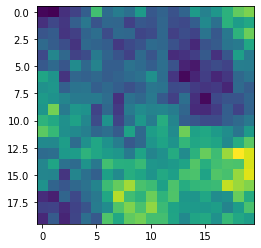

In [8]:
f = get_z_stack(image)
plt.imshow(f[0,:,:])
plt.show()
print(np.shape(f)) # check dimensions of f are the same as image from OMERO

Check that numpy mean, and the axis attribute, do what I think:

In [31]:
g=f[:,0,0] # vector intensity at each time point for one pixel 
print('Intensity of one pixel in time: ', g)
print('Mean over time for that one pixel: ', np.mean(g))
test=np.mean(f, axis = 0) #calculate mean over time for all points
print('Calculating mean over time for whole array, then selecting the same pixel: ',test[0,0])

Intensity of one pixel in time:  [157 190 190 190 176 165 162 177 190 175 193 233 175 177 170 170 172 169
 170 198 201 219 245 188 210 216 178 204 169 201]
Mean over time for that one pixel:  187.66666666666666
Calculating mean over time for whole array, then selecting the same pixel:  187.66666666666666


## Calculate turbulence statistics
I've used the names from turbulence, but these should probably be given different names since we're looking at changes in intensity of the pixels

In [37]:
# mean velocity over time for every pixel
u_bar=np.mean(f, axis = 0);
print('The mean velocity over both time and space is:',np.mean(u_bar, axis=(0,1)))
# Reynolds decomposition to calculate turbulent fluctuations
u_fluct=np.subtract(f,u_bar)

The mean velocity over both time and space is: 261.1308333333333


In [41]:
#Turblence Strength
u_rms=np.std(u_fluct, axis = 0)
print('The mean turblence strength (in space) is:',np.mean(u_rms, axis=(0,1)))

The mean turblence strength (in space) is: 26.47446298014719


Plot for one pixel

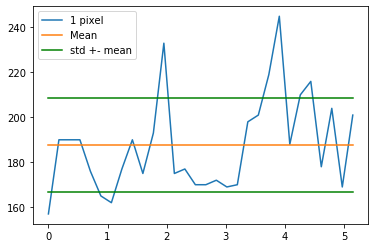

In [55]:
t=0.1775*np.arange(0,30,1);
plt.plot(t,f[:,0,0],label='1 pixel')
plt.plot(t,u_bar[0,0]*np.ones(30),label='Mean')
plt.plot(t,(u_rms[0,0]+u_bar[0,0])*np.ones(30),color='green')
plt.plot(t,(-u_rms[0,0]+u_bar[0,0])*np.ones(30),color='green',label='std +- mean')
plt.legend(loc='upper left')
plt.show()

## Frequency Domain
Study the frequency domain to see if there are differences between the different samples

### Example 1D FFT
Just to check the FFT part does what I think it should

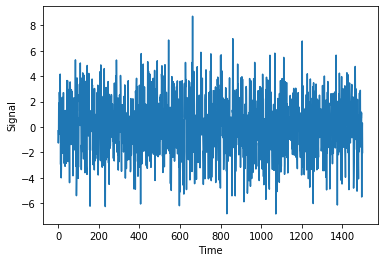

In [65]:
# Create a signal with some noise
#np.random.seed(10)
Fs=1000; #Sample freqency
L=1500 # Length of signal
T = 1/Fs; #Sampling period   
t=np.arange(0,L,1)*T # Time Vector
Hz1=50; #Signal 1\n",
Hz2=120; #Signal 2\n",
F=np.sin(2*np.pi*Hz1*t)+np.sin(2*np.pi*Hz2*t)+2*(np.random.randn(len(t)))
plt.plot(1000*t,F)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show;

Use Fourier Transform to identify frequence of signals

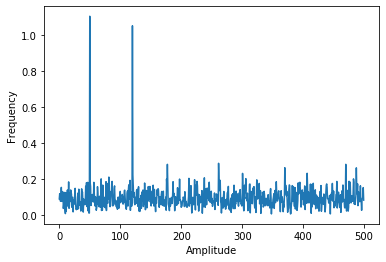

In [66]:
Y=fft.fft(F); # Fourier transform of function\n",
P2=abs(Y/L) #2 sided spectrum\n",
P1=P2[0:int(L/2)]; #1 sided spectrum\n",
P1[1:len(P1)-1]=2*P1[1:len(P1)-1];
fd=Fs*np.arange(0,L/2,1)/L; #Freqency fomain\n",
plt.plot(fd,P1)
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.show;

### Back to Image
Start with just one pixel

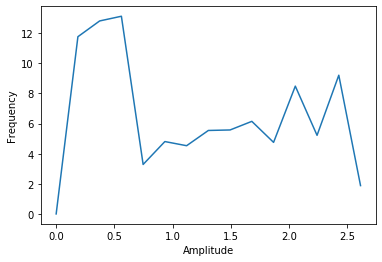

In [71]:
Fs=5.6; #Sample freqency (Frame length is 0.1775 seconds according to paper)
L=30 # Length of signal 

v_fft=fft.fft(u_fluct[:,0,0])
#should put this bit in a function
P2=abs(v_fft/L) #2 sided spectrum\n",
P1=P2[0:int(L/2)]; #1 sided spectrum\n",
P1[1:len(P1)-1]=2*P1[1:len(P1)-1];
fd=Fs*np.arange(0,L/2,1)/L; #Freqency fomain\n",
plt.plot(fd,P1)
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.show;

### All pixels
Calcalate for all pixels and then plot just one to see if its the same

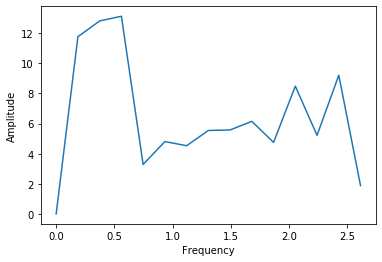

In [94]:
Fs=5.6; #Sample freqency
L=30 # Length of signal 

u_fft=fft.fft(u_fluct, axis = 0)
P2=abs(u_fft/L) #2 sided spectrum\n",
P1=P2[0:int(L/2)]; #1 sided spectrum\n",
P1[1:len(P1)-1]=2*P1[1:len(P1)-1];
fd=Fs*np.arange(0,L/2,1)/L; #Freqency fomain\n",
plt.plot(fd,P1[:,0,0])
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.show;

Plot pixels on the diagonal to see what a few look like

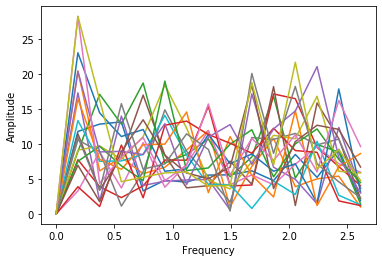

In [96]:
for i in range(19):
    plt.plot(fd,P1[:,i,i])
    
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.show;

Plot mean of frequency spectrums of all pixels

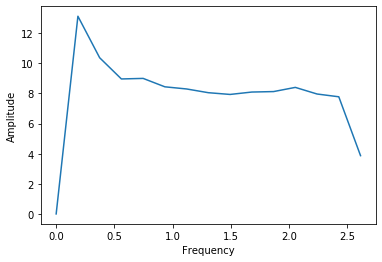

In [106]:
P1_mean=np.mean(P1,axis=(1,2))

fig, ax1 = plt.subplots()
plt.plot(fd,P1_mean) # comment out to plot on log scale
#plt.plot(fd[1:],P1_mean[1:]) # uncomment to plot on log scale

plt.ylabel('Amplitude')
plt.xlabel('Frequency')
#plt.yscale('log') # uncomment to plot on log scale
plt.show;

Average in space first. I don't think this makes sense

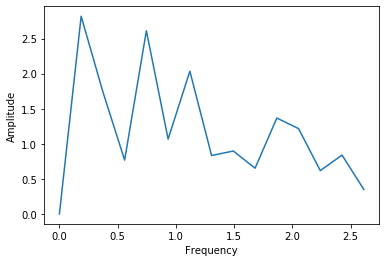

In [111]:
u_fluct_mean=np.mean(u_fluct, axis=(1,2))
u_fft_mean=fft.fft(u_fluct_mean)
P2_mean=abs(u_fft_mean/L) #2 sided spectrum\n",
P1_mean=P2_mean[0:int(L/2)]; #1 sided spectrum\n",
P1_mean[1:len(P1_mean)-1]=2*P1_mean[1:len(P1_mean)-1];
plt.plot(fd,P1_mean)
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.show;